# EBUS-ENSO Timeseries Analysis
- Taking output from the EBUS_extraction.py script to analyze it in coordination with Adam Phillip's CVDP output (starting with Nino 3.4)
- First step is to work with CCS, since that's a comfortable area.

In [1]:
# UNIX-style globbing
import glob

# Numerics
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText


from pylab import *

from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set(color_codes=True)

import statsmodels.api as sm

import scipy.fftpack

# Functions
- For visibility in the Notebook

In [2]:
# Constants
colors = {
    'CalCS': '#80b1d3',
    'HumCS': '#fb8072',
    'CanCS': '#fdb462',
    'BenCS': '#bc80bd'
}
ens = ['001', '002', '009', '010', '011',
       '012', '013', '014', '015', '016',
       '017', '018', '019', '020', '021',
       '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031',
       '032', '033', '034', '035', '101',
       '102', '103', '104', '105']

In [3]:
def detrend_nino(x):
    return signal.detrend(x)

In [4]:
def compute_correlations(carbonData, climateData):
    slope, intercept, r_value, p_value, std_err = stats.linregress(climateData, carbonData)
    return slope, r_value, r_value**2, p_value

In [5]:
def smooth_series(x, length=12):
    return pd.rolling_mean(x, length, center=False)

In [6]:
def drop_ensemble_dim(ds, x):
    ds[x] = (('nlat','nlon'), ds[x][0])
    return ds

In [7]:
def setup_map(ax, lon, lat, lat1=np.nan, lat2=np.nan,
              lon1=np.nan, lon2=np.nan):
    if np.isnan(lat1):
        lat1=np.nanmin(lat)
        lat2=np.nanmax(lat)
        lon1=np.nanmin(lon)
        lon2=np.nanmax(lon)
    m = Basemap(projection='eqdc',
                lat_0=(lat1 + lat2)/2,
                lon_0=(lon1 + lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                resolution='c')
    m.drawcoastlines()
    #m.fillcontinents(color='black')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(np.floor(np.nanmin(lat)), 
                              np.ceil(np.nanmax(lat)), 3),
                   labels=[True,False,False,False], size='x-large')
    m.drawmeridians(np.arange(np.floor(np.nanmin(lon)), 
                              np.ceil(np.nanmax(lon)), 3),
                   labels=[False, False, False, True], size='x-large')
    return m

In [8]:
def chavez_bounds(x):
    if x == "CalCS":
        lat1 = 34
        lat2 = 44
    elif x == "CanCS":
        lat1 = 12
        lat2 = 22
    elif x == "BenCS":
        lat1 = -28
        lat2 = -18
    elif x == "HumCS":
        lat1 = -16
        lat2 = -6
    else:
        raise ValueError('\n' + 'Must select from the following EBUS strings:'
                         + '\n' + 'CalCS' + '\n' + 'CanCS' + '\n' + 'BenCS' +
                         '\n' + 'HumCS')
    return lat1, lat2

# Filter Region

In [9]:
EBU = "BenCS"
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + EBU + '/'
ds = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')

In [10]:
# Reduce ensemble dimension for coordinates.
ds = drop_ensemble_dim(ds, 'DXT')
ds = drop_ensemble_dim(ds, 'TAREA')
ds = drop_ensemble_dim(ds, 'REGION_MASK')
ds = drop_ensemble_dim(ds, 'TLAT')
if EBU != "HumCS":
    ds = drop_ensemble_dim(ds, 'TLONG')
del ds['DYT']
del ds['ANGLET']
# Convert DXT to kilometers.
ds['DXT'] = ds['DXT'] / 100 / 1000

In [11]:
# Filter out latitude 
lat1, lat2 = chavez_bounds(EBU)
ds = ds.where(ds['TLAT'] >= lat1).where(ds['TLAT'] <= lat2)

In [12]:
# Create a masked array for DXT since it doesn't follow the same NaN structure.
co2 = ds['FG_CO2'][0,0]
co2 = np.ma.array(co2, mask=np.isnan(co2))
dxt_dat = ds['DXT']
dxt_dat= np.ma.array(dxt_dat, mask=np.isnan(co2))
ds['DXT'] = (('nlat','nlon'), dxt_dat)

In [13]:
# Filter out rows without a coastline to reference.
regmask = ds['REGION_MASK']
counter = 0 
for row in regmask:
    conditional = 0 in row.values
    if conditional == False:
        ds['DXT'][counter, :] = np.nan
    counter += 1

In [14]:
# Now create new variable for dist2coast
x = ds['DXT'].values
x = np.ma.array(x, mask=np.isnan(x))
dxt_cum = np.cumsum(x[:, ::-1], axis=1)[:, ::-1]
ds['DXT_Cum'] = (('nlat','nlon'), dxt_cum)

In [15]:
# Filter within 800km of coastline.
ds = ds.where(ds['DXT_Cum'] <= 800)

In [16]:
ds_residuals = ds['FG_CO2'] - ds['FG_CO2'].mean(dim='ensemble')

In [17]:
# Area-weighting
ds_residuals = ((ds_residuals * ds['TAREA']).sum(dim='nlat').sum(dim='nlon'))/ds['TAREA'].sum()

# Plot Study Region

In [ ]:
# Convert all non-nan values to a constant to just plot the domain as one color.
data = np.asarray(ds['FG_CO2'][0].mean(dim='time'))
mask = ~np.isnan(data)
data[mask] = 999

In [ ]:
lon = ds['TLONG'].values
lat = ds['TLAT'].values
#data = ds['FG_CO2'][0].mean(dim='time')
data = np.ma.array(data, mask=np.isnan(data))


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
m = setup_map(ax,lon,lat)
m.drawcountries()
#m.drawstates()
m.pcolor(lon, lat, data, vmin=0, vmax = 1500,
          latlon=True, cmap="Blues", edgecolors='white')
plt.title('Humboldt Current Study Site', size=24)
#plt.savefig('canary-current-study-site.png')

# Residuals Plotting
Create a residuals dataset from the above and compare it to climate data

In [ ]:
fig = plt.figure(figsize=(18,4))
ds_residuals[0].plot()
plt.xlabel('Time', size='x-large')
plt.ylabel('FG_CO2 (mol/m2/yr)', size='x-large')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Simulation 001 CCS FG_CO2 Anomaly (1920-2015)', size='x-large')
#plt.savefig('ccs-unfiltered-fgco2-series-example.png')

# Smooth Series

In [ ]:
data = ds_residuals[0].values
smoothed_data = smooth_series(data, 12)

In [ ]:
fig = plt.figure(figsize=(18,4))
t = ds_residuals['time'].values
plt.plot(t, data, color=colors[EBU])
plt.plot(t, smoothed_data, '-k')
plt.ylabel('FG_CO2 (mol/m2/yr)', size=20)
plt.title('Simulation 001 BenCS FG_CO2 Anomaly, Annual Smoothing (1920-2015)', size=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('bencs-filtered-fgco2-series-example.png')

# FFT

In [ ]:
data = ds_residuals[0].values
hann = np.hanning(len(data))

In [ ]:
Y = np.fft.fft(hann*data)

In [ ]:
N = len(Y)/2+1

In [ ]:
T = 1.0/(30*24*60*60) # Sampled once every month
X = np.linspace(0, T/2, N, endpoint=True)

In [ ]:
fig = plt.figure(figsize=(18,4))
plt.plot(X, 2.0*np.abs(Y[:N])/N, color='r')
plt.xlabel('Frequency ($Hz$)', size='x-large')
plt.title('FFT of HCS FG_CO2 for Simulation 001', size='x-large')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('fft-HCS-001-frequencyHz.png')

In [ ]:
# Same plot but in Period
Xp = 1.0/X # Inverse to seconds
Xpd= Xp/(60.0 * 60.0 * 24) # in days
fig = plt.figure(figsize=(18,4))
plt.plot(Xpd, 2.0*np.abs(Y[:N])/N, color='r')
plt.xlabel('Frequency ($Hz$)', size='x-large')
plt.title('FFT of HCS FG_CO2 for Simulation 001', size='x-large')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim([0, 365])

# CVDP -- Adam Phillips
- Messing with the climate diagnostics that Adam Phillips provides

In [18]:
fileDir = '/glade/p/work/rbrady/cesmLE_CVDP/extracted_vars/'
ds_cvdp = xr.open_mfdataset(fileDir + '*.nc', decode_times=False, concat_dim='ensemble')

In [19]:
ds_cvdp = ds_cvdp.rename({'npo_pc_mon': 'npo', 
                          'pdo_timeseries_mon': 'pdo',
                          'sam_pc_mon': 'sam',
                          'ipo_timeseries_mon': 'ipo',
                          'amo_timeseries_mon': 'amo',
                          'nao_pc_mon': 'nao'})

In [20]:
times = pd.date_range('1920-01', '2016-01', freq='M')
ds_cvdp['time'] = times

In [21]:
ds_cvdp = ds_cvdp.apply(detrend_nino)

In [ ]:
fig = plt.figure(figsize=(18,4))
nino_dat = ds_cvdp['nino34'][0]
t = nino_dat.time.values
pos = nino_dat.where(nino_dat > 0)
neg = nino_dat.where(nino_dat < 0)

ax1 = fig.add_subplot(111)
ax1.bar(t, pos, color='none', edgecolor='red')
ax1.bar(t, neg, color='none', edgecolor='blue')
ax1.set_ylabel('Nino 3.4 Index')

ax2 = ax1.twinx()
ax2.plot(t, smoothed_data, '-k')
ax2.set_ylabel('FG_CO2 Anomalies (mol/m2/yr)')

ax1.grid('off')
ax2.grid('off')

plt.title('Simulation 001 Nino3.4 Index + Smoothed FG_CO2 Anomalies')
#fig.savefig('ccs-smoothed-fgco2-and-nino34-plot.png')
#fig.savefig('ccs-smoothed-fgco2-and-nino34-plot.eps')

# Cross-Correlation Plots

In [22]:
def cross_correlate(idx, ds_residuals, ds_cvdp, climvar):
    print('Working on {}...').format(idx)
    data = ds_residuals[idx]
    data = smooth_series(data.values)
    data = data[11::]
    clim_data = ds_cvdp[climvar][idx]
    clim_data = clim_data[11::]
    return data, clim_data

Working on 0...


/glade/u/apps/opt/jupyter/5.0.0/gnu/4.8.2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


Working on 1...
Working on 2...
Working on 3...
Working on 4...
Working on 5...
Working on 6...
Working on 7...
Working on 8...
Working on 9...
Working on 10...
Working on 11...
Working on 12...
Working on 13...
Working on 14...
Working on 15...
Working on 16...
Working on 17...
Working on 18...
Working on 19...
Working on 20...
Working on 21...
Working on 22...
Working on 23...
Working on 24...
Working on 25...
Working on 26...
Working on 27...
Working on 28...
Working on 29...
Working on 30...
Working on 31...
Working on 32...
Working on 33...


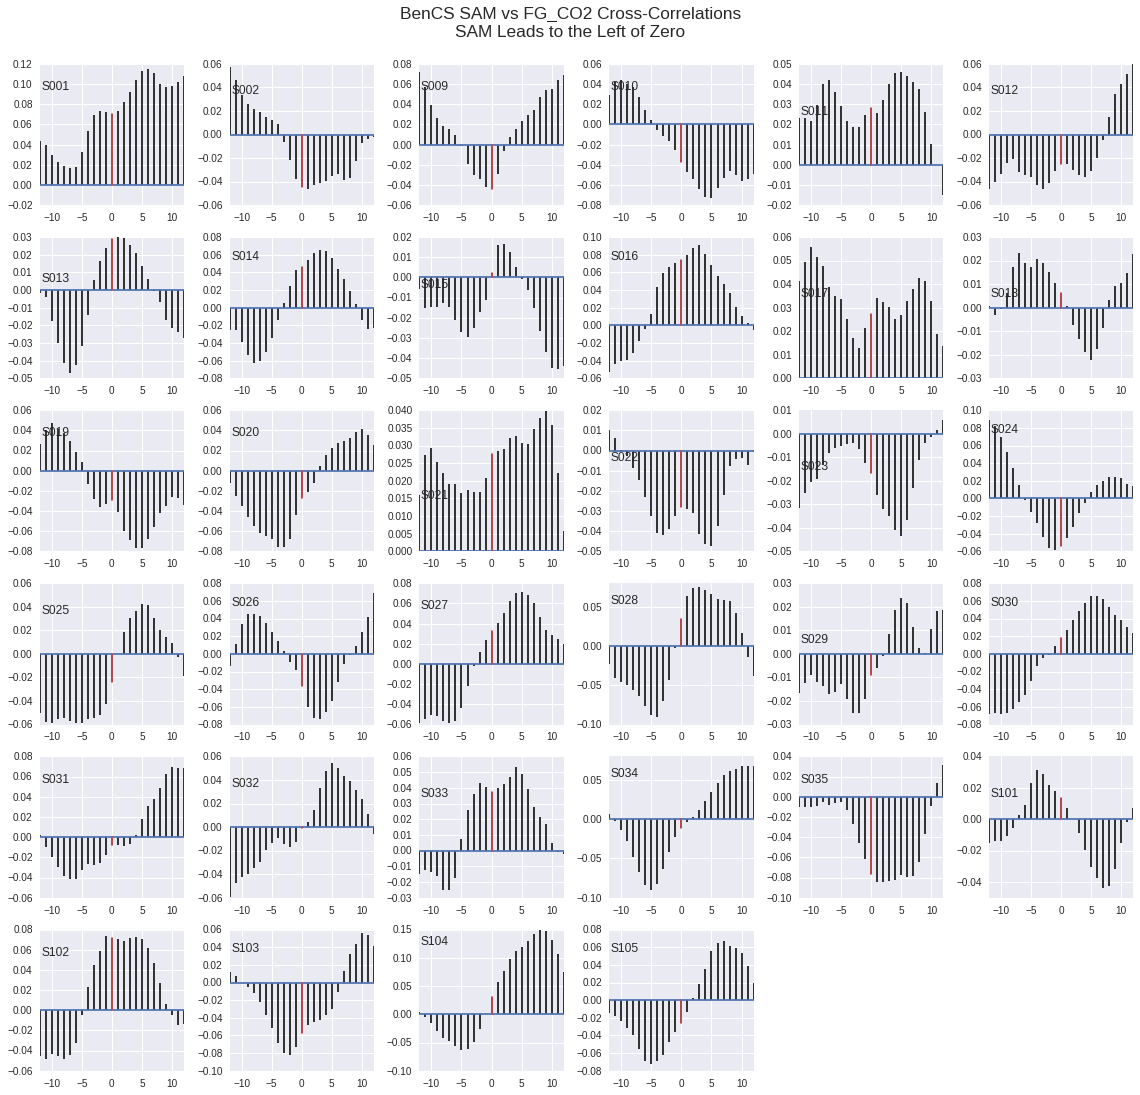

In [26]:
climvar = 'sam'

fig = plt.figure(figsize=(16,16))
st = fig.suptitle("BenCS SAM vs FG_CO2 Cross-Correlations" + "\n" + "SAM Leads to the Left of Zero", fontsize="x-large")
for idx in range(34):
    data, clim_data = cross_correlate(idx, ds_residuals, ds_cvdp, climvar)
    ax = fig.add_subplot(6, 6, idx+1)
    arr = plt.xcorr(clim_data, data, maxlags=12)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.text(-11.75, ymax-0.025, "S" + ens[idx])
    plt.xlim([-12, 12])
    # Show zero boundary
    zero_val = arr[1][12]
    plt.plot([0,0], [0,zero_val], '-r')
fig.tight_layout()
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.90)
plt.savefig("SAM_FGCO2_cross-correlation_BenCS.png")